# EM for Document Clustering
In this project, we solved a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization) for document clustering.

First we derive Expectation and Maximization steps of the hard-EM algorithm for Document Clustering, including all model parameters that should be learnt and the exact expression that should be used to update these parameters during the learning process

Given a collection of documents $\{d_1,…,d_N\}$ we would like to partition them into ${K}$ clusters. Each document $d_n$ is composed by a set of words $\{w_1,…,w_N\}$ called `Bag of Words`, as we treat each document as a set of words in its text irrespective of their positions. Also, we assume the words appearing in our collection of documents come from a dictionary denoted by $\mathcal{A}$ (corpus).

The document clusters were not given to us, so $z_n$ is latent. So, the probability of the observed documents is

$$\begin{aligned} 
p(d_1, ..., d_N) = \prod_{n=1}^{N} p(d_n) &= \prod_{n=1}^{N} \sum_{k=1}^Kp(z_{n,k} = 1, d_n) \\
                                          &= \prod_{n=1}^{N} \sum_{k=1}^K \left(\varphi_k \prod_{w \in \mathcal{A}} \mu_{k,w}^{c(w,d_n)}\right) \\
\end{aligned}$$

  **Where:**
   - **$N$:** Number of documents
   - **$K$:** Number of Clusters
   - **$\varphi$:** Probability vector of size K
   - **$\mu_k$:** Word proportion corresponding to the $k^{th}$ face of the dice
   - **$c(w, d_n)$:** Number of occurences of word $w$ in document $d_n$
   

The log-likelihood is:

$$\begin{aligned} 
\text{ln } p(d_1, ..., d_N) = \sum_{n=1}^{N} \text{ln } p(d_n) &= \sum_{n=1}^{N} \text{ln }\sum_{k=1}^Kp(z_{n,k} = 1, d_n) \\
                                          &= \sum_{n=1}^{N} \text{ln } \sum_{k=1}^K \left(\varphi_k \prod_{w \in \mathcal{A}} \mu_{k,w}^{c(w,d_n)}\right) \\
\end{aligned}$$
$$ $$
To maximise the above incomplete data log-likelihood objective, we resort to the **EM Algorithm**

The **Q Function** will be the basis of our EM Algorithm:

$$\begin{aligned} 
Q(\theta, \theta^{\text{old}}) &:= \sum_{n=1}^{N}\sum_{k=1}^K p(z_{n,k} = 1| d_n, \theta^{\text{old}}) \text{ ln }p(z_{n,k} = 1, d_n| \theta)\\
&= \sum_{n=1}^{N}\sum_{k=1}^K p(z_{n,k} = 1| d_n, \theta^{\text{old}}) \left(\text{ ln }\varphi_k + \sum_{w \in \mathcal{A}}c(w, d_n) \text{ ln} \mu_{k,w}\right)\\
&= \sum_{n=1}^{N}\sum_{k=1}^K \gamma(z_{n,k})\left(\text{ ln }\varphi_k + \sum_{w \in \mathcal{A}}c(w, d_n) \text{ ln} \mu_{k,w}\right)
\end{aligned}$$
$$ $$
where **$\theta := (\varphi, \mu_1,...,\mu_k)$** is the collection of model parameters, and **$\gamma(z_{n,k}) := p(z_{n,k} = 1| d_n, \theta^{\text{old}})$** are the responsibility factors.

Forming the Lagrangian to enforce the constraints, and set the derivatives to zero. We get the following solution for the model parameters:
   - The mixing components: $\varphi_k = \frac{N_k}{N}$ where $N_k := \sum_{n=1}^N \gamma(z_{n,k})$
   - The word proportion parameters for each cluster: $\mu_{k,w} = \frac{\sum_{n=1}^N \gamma(z_{n,k})c(w, d_n)}{\sum_{w' \in \mathcal{A}}\sum_{n=1}^{N} \gamma(z_{n,k})c(w',d_n)}$
$ $

**The hard EM Algorithm**                                
Now let's put everything together to construct our hard EM algorithm to learn the parameters and find value for the latent variables:

   - Choose an initial setting for the parameters 
   $$\theta^{\text{old}} = \left(\varphi^{\text{old}}, \mu_1^{\text{old}},...,\mu_K^{\text{old}}\right)$$
   - While the convergence is not met:
      - **E step:** Set $\forall n, \forall k: \gamma (z_{n,k}) = \text{argmax}\left(p(z_{n,k} = 1| d_n, \theta^{\text{old}})\right)$                                                
      *For each document ($d_n$), set a responsability factor of 1 to the cluster $K$ if it is the one with the higher probability, if not set a responsability factor of 0*                                       
               
      - **M Step:** Set $\theta^{\text{new}}$ based on the above equations (new responsability factors of the *E Step*)
      
      - $\theta^{\text{old}} \leftarrow \theta^{\text{new}}$

Afterward, we implemented the hard-EM and soft-EM, we derived above. 

### Import Libraries

In [10]:
options(warn=-1) # Avoid anoying error warnings
library(ggplot2) # plotting
library(reshape2) # data wrangling!
library(tm) # load Text Mining library 
library(SnowballC) # load Text Mining librarya

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



### Function Read Data
This function reads the .txt file with the information and return three different variables:
   -  **docs:** The text of the documents already preprocessed 
   - **word.doc.mat:** The matrix that stores the count of words per document, it has dimensions (W x N) 
   - **labels:** The true label of each document

In [21]:
# reading the data
read.data <- function(file.name, sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  docs <- as.data.frame(cbind(doc_id = row.names(docs), text = docs))   
  names(docs) <- c('doc_id', 'text')
  
  
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

### Function LogSum
**Input:**    $\text{log}(A_1), \text{log}(A_2), ... , \text{log}(A_n)$                  
**Output:**   $\text{log}(A_1 + A_2 + ... + A_n)$         

This function is needed to prevent numerical overflow/underflow when working with small numbers, because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   

*Example:* Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities in [0,1] To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function. Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] Then get the results by: exp(logSum(v))

In [22]:
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

### Initialize model parameters randomly

In [23]:
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)   # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

### E Step for Document Clustering
Set $\forall n, \forall k: \gamma (z_{n,k}) $

#### Hard Clustering

$$\gamma (z_{n,k}) = \text{argmax}\left(p(z_{n,k} = 1| d_n, \theta^{\text{old}})\right)$$


*For each document ($d_n$), set a responsability factor of 1 to the cluster $K$ if it is the one with the higher probability, if not set a responsability factor of 0* 

#### Soft Clustering

$$\gamma (z_{n,k}) = p(z_{n,k} = 1| d_n, \theta^{\text{old}})$$


In [24]:
E.step <- function(gamma, model, counts, hard = FALSE){
    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

    # E step:    
    for (n in 1:N){
        for (k in 1:K){
        ## calculate the posterior based on the estimated mu and rho in the "log space"
            gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
        }
        
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
      }
  
    # converting back from the log space 
    gamma <- exp(gamma)
    
    # If Hard it is a Hard Clusterization
    if (hard){ # If it is a Hard Clusterisation
        for (n in 1:N){ # For every document
            cluster = which.max(gamma[n, ]) # Find the maximum value of Q
            gamma[n, cluster] = 1    # If the cluster is the maximum asign a responsability factor of 1
            gamma[n, -cluster] = 0   # If is it not the maximum cluster asign a responsability factor of 0

        }

    }
    return (gamma)
}

### M Step for Document Clustering
 Set $\theta^{\text{new}}$ based on the above equations (new responsability factors of the *E Step*)
      
$$\theta^{\text{old}} \leftarrow \theta^{\text{new}}$$

In [25]:
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  colsums <- as.data.frame(colSums(counts)) 
  #M step: 
  for (k in 1:K){
    Nk <- 0  
    for (n in 1:N){
       Nk <- Nk + gamma[n,k]
    }  
      #updating rho value based on gamma value
    model$rho[k,1] <- Nk/N  
  }    
   #updating mu value based on gamma value
  for(k in 1:K){   
    normalize_sum <- 0   
    for (w in 1:W){
       num <- 0
       denom <- 0 
       for(n in 1:N){
           num <- num + counts[w,n]*gamma[n,k]
           countnotwords <- colsums[n,]-counts[w,n]
           denom <- denom + countnotwords*gamma[n,k]
       }  
       model$mu[k,W] = (num/denom)+eps
       normalize_sum <- normalize_sum + model$mu[k,W] 
    }
    for(w in 1:W){
        model$mu[k,W] <- model$mu[k,W]/normalize_sum
    }
  }
  
  # Return the result
  return (model)
}

### EM Algorithm
Now let's put everything together to construct our EM algorithm to learn the parameters and find the best value for the latent variables

In [26]:
EM <- function(counts, K=4, max.epoch=10, seed=123456, hard=FALSE){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  ## Hard: Define if it is a hard of soft clusterization
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  logdiff <- train_obj(model,counts)
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts, hard)
    # M Step
    model <- M.step(gamma, model, counts)
    
    newlogdiff <- train_obj(model,counts)
    print(newlogdiff) 
    #checking for convergence  
    flag <- logdiff - newlogdiff
    if(flag< 1e-4){
      break
    } 
    else{
      logdiff <- newlogdiff
    }  
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

### The training objective function

In [27]:
train_obj <- function(model, counts) { 
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

### Cluster Visualization

In [28]:
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

III. Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [36]:
# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./data/Documents.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
eps <- 1e-10
# word-document frequency matrix 
counts <- data$word.doc.mat

# calling the EM algorithm on the data
soft_EM <- EM(counts, K=5, max.epoch=5, seed=123456, hard=FALSE)   
hard_EM <- EM(counts, K=5, max.epoch=5, seed=123456, hard=TRUE)  

# visualization
## find the cluster with the maximum probability (since we have soft assignment here)
label.hat_soft <- apply(soft_EM$gamma, 1, which.max) 

## Assign the cluster, even thought we did Hard Clustering we have to select the cluster with a value of 1 (max)
label.hat_hard <- apply(hard_EM$gamma, 1, which.max) 

## normalize the count matrix for better visualization
counts <- scale(counts) # only use when the dimensionality of the data (number of words) is large enough

[1] 2175724
[1] 2175714
[1] 2175714
[1] 2175714
[1] 2175714
[1] 2174654


IV. Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM in the same way we did in Activity 4.2. Then, visualize the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2). Attach the plots to your PDF report and report how and why the hard and soft-EM are different, based on your plots in the report.

## Soft Clustering

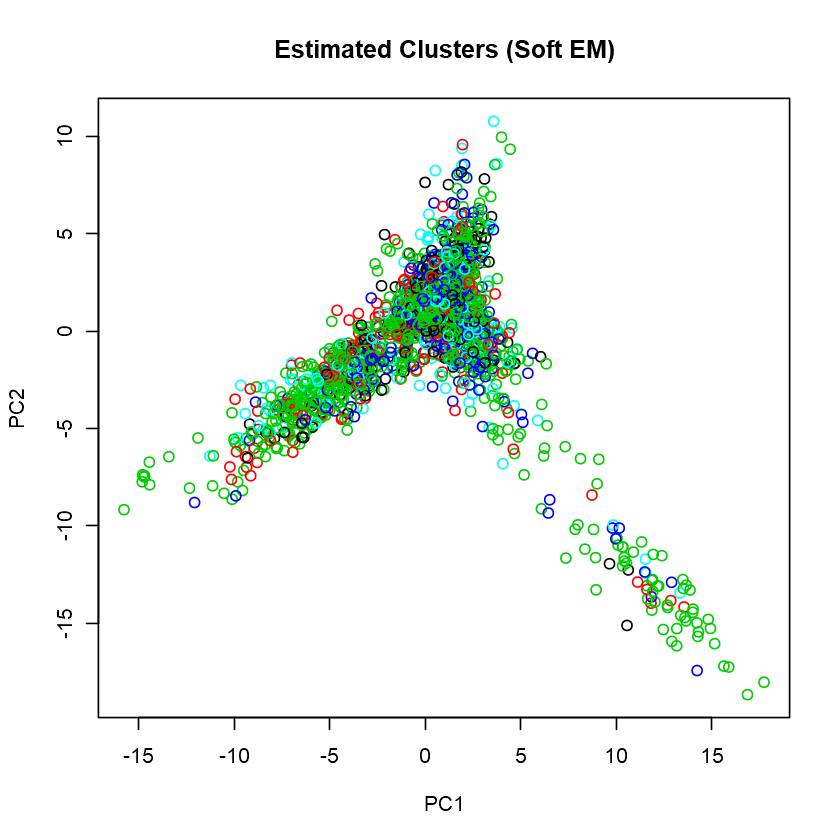

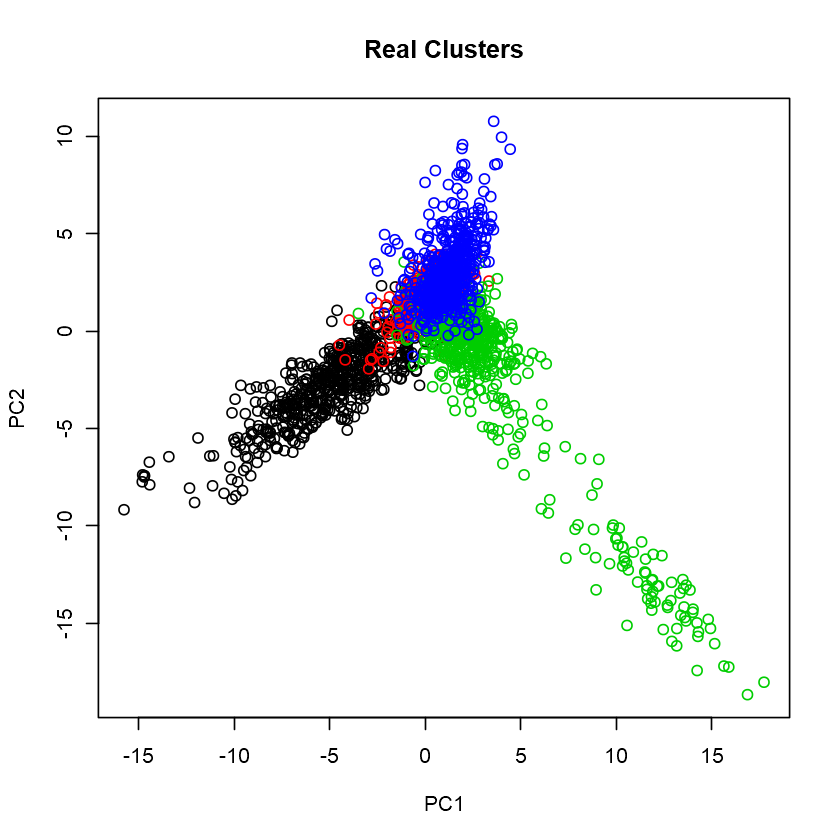

In [37]:
## visualize the stimated clusters
cluster.viz(t(counts), label.hat_soft, 'Estimated Clusters (Soft EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')

## Hard Clustering

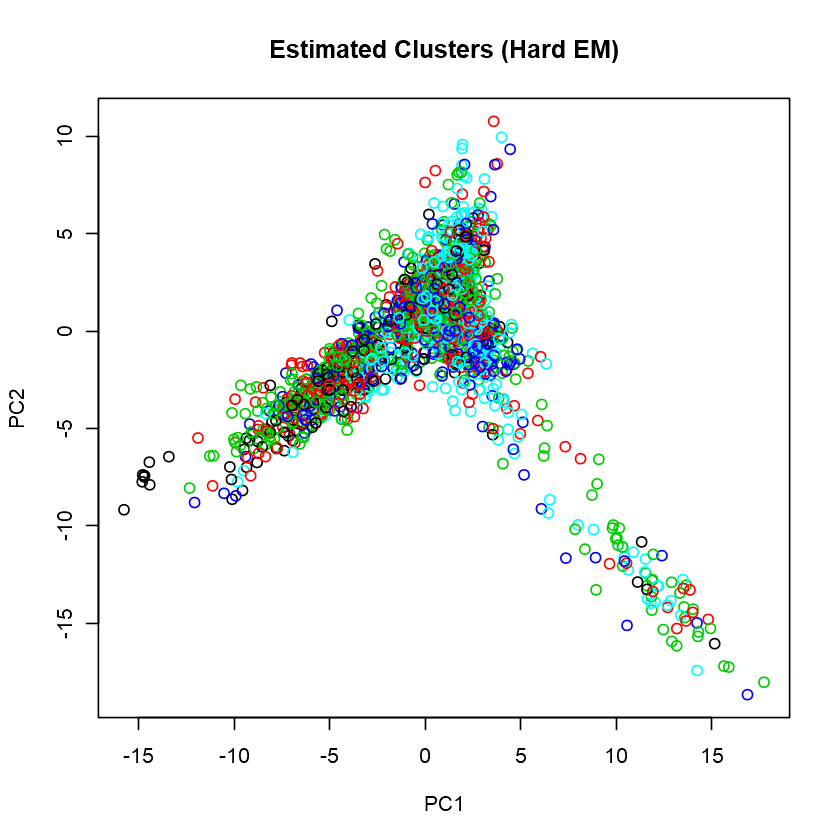

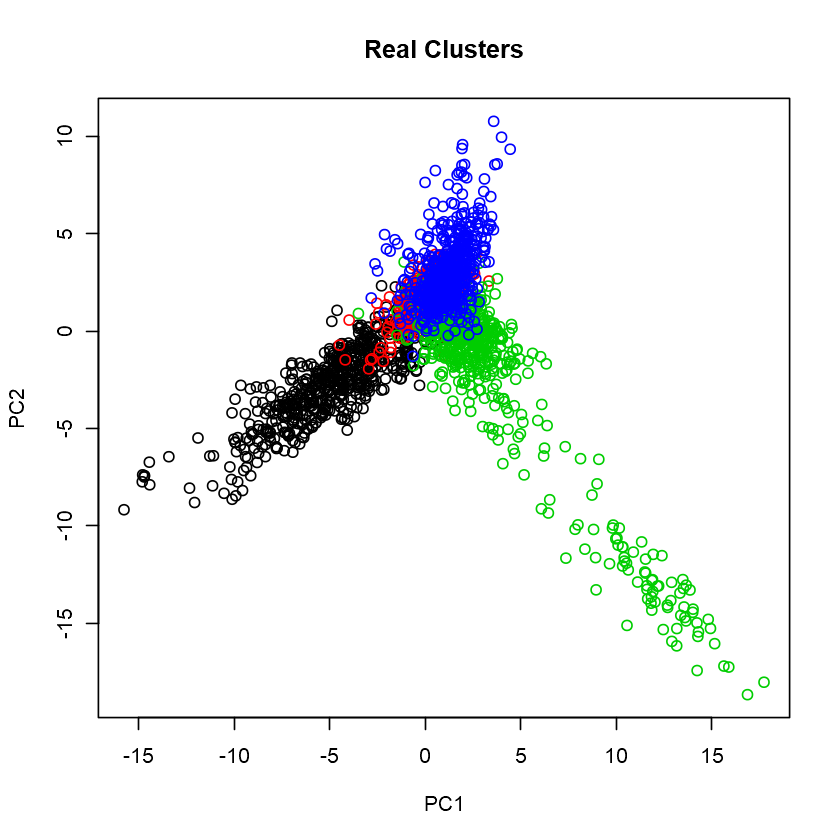

In [38]:
## visualize the stimated clusters
cluster.viz(t(counts), label.hat_hard, 'Estimated Clusters (Hard EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')